# Supervised Machine Learning

In [64]:
#data mining
import os
import warnings
import pickle
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = 'C:/Users/aless/OneDrive - Università degli Studi di Catania/tesi/dataset/scaled_dataset.csv'

#training
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_validate, StratifiedGroupKFold, HalvingGridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#selection
from mlxtend.evaluate import mcnemar_table, mcnemar
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#interpretability
from sklearn.inspection import PartialDependenceDisplay
import shap

#deployment
from micromlgen import port

In [54]:
df = pd.read_csv(path, index_col=0)
df.head()

,min_hr,max_hr,mean_hr,median_hr,var_hr,std_hr,skew_hr,kurt_hr,min_st,max_st,mean_st,median_st,var_st,std_st,skew_st,kurt_st,target,ID
0,0.447531,0.44192,0.469939,0.464876,0.008988,0.094470,0.531569,0.035987,0.928227,0.944060,0.937919,0.937014,0.002369,0.048639,0.504285,0.051480,0.0,0
1,0.447658,0.44192,0.471027,0.466061,0.008589,0.092343,0.527895,0.037719,0.928227,0.944060,0.937961,0.937014,0.002371,0.048661,0.503165,0.051407,0.0,0
2,0.447722,0.44192,0.472097,0.467611,0.008139,0.089878,0.524656,0.039461,0.928227,0.944667,0.937979,0.937014,0.002392,0.048870,0.504175,0.051732,0.0,0
3,0.448104,0.44192,0.473156,0.469282,0.007640,0.087072,0.522211,0.040991,0.928227,0.944667,0.938063,0.937014,0.002406,0.049017,0.502161,0.051341,0.0,0
4,0.449060,0.44192,0.474201,0.470771,0.007106,0.083957,0.520813,0.042076,0.928227,0.948555,0.938160,0.937014,0.002527,0.050240,0.508913,0.054240,0.0,0


In [55]:
X = df.drop(['ID', 'target'], axis=1, inplace=False)
y = df.target
groups = df.ID

In [56]:
false = (y == 0).sum()
true = (y == 1).sum()

print(false)
print(true)

18780
11220


## Hyperparameter Optimization

### Logistic Regression

In [7]:
parameters_logreg = {'penalty':('l1', 'l2', 'elasticnet'), 
                     'solver':('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'),
                     'C': np.logspace(-3, 0, 10)}
logreg = LogisticRegression(random_state=46, class_weight = 'balanced')
cv = StratifiedGroupKFold(n_splits=15, shuffle=True, random_state=46)
logreg_hyperparams = HalvingGridSearchCV(logreg, parameters_logreg, cv = cv, scoring = 'f1_weighted', random_state=46, verbose=3)
logreg_hyperparams.fit(X, y, groups = groups)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 370
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 180
n_resources: 370
Fitting 15 folds for each of 180 candidates, totalling 2700 fits
[CV 1/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 7/15] END C=0.001, penalty=l1, solver=lbfgs;, score=(train=nan, test=nan) total time=   0.0s
[CV 8/15] END C=0.001, penalty=l1, solver=lbfgs;, scor

HalvingGridSearchCV(cv=StratifiedGroupKFold(n_splits=15, random_state=46, shuffle=True),
                    estimator=LogisticRegression(class_weight='balanced',
                                                 random_state=46),
                    param_grid={'C': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                'penalty': ('l1', 'l2', 'elasticnet'),
                                'solver': ('lbfgs', 'liblinear', 'newton-cg',
                                           'newton-cholesky', 'sag', 'saga')},
                    random_state=46, scoring='f1_weighted', verbose=3)

In [8]:
print(logreg_hyperparams.best_params_)
print(logreg_hyperparams.best_score_)

{'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
0.7313092110846856


In [78]:
logreg = logreg_hyperparams.best_estimator_

In [5]:
logreg = LogisticRegression(random_state=46, class_weight = 'balanced', C = 1.0, penalty = 'l1', solver = 'saga')

### Random Forest

In [57]:
parameters_rf = {'n_estimators': [5, 10, 20, 30, 50, 100],
               'max_depth': [5, 10, 20, 30],
               'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier(random_state=46, class_weight= 'balanced')
rf_hyperparams = HalvingGridSearchCV(rf, parameters_rf, cv = cv, scoring = 'f1_weighted', random_state=46, verbose=3)
rf_hyperparams.fit(X, y, groups = groups)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1111
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 1111
Fitting 15 folds for each of 72 candidates, totalling 1080 fits
[CV 1/15] END max_depth=5, min_samples_split=2, n_estimators=5;, score=(train=0.928, test=0.922) total time=   0.0s
[CV 2/15] END max_depth=5, min_samples_split=2, n_estimators=5;, score=(train=0.907, test=0.446) total time=   0.0s
[CV 3/15] END max_depth=5, min_samples_split=2, n_estimators=5;, score=(train=0.923, test=0.889) total time=   0.0s
[CV 4/15] END max_depth=5, min_samples_split=2, n_estimators=5;, score=(train=0.910, test=0.550) total time=   0.0s
[CV 5/15] END max_depth=5, min_samples_split=2, n_estimators=5;, score=(train=0.921, test=0.735) total time=   0.0s
[CV 6/15] END max_depth=5, min_samples_split=2, n_estimators=5;, score=(train=0.939, test=0.082) total time=   0.0s
[CV 7/15] END max_depth=5, min_sample

HalvingGridSearchCV(cv=StratifiedGroupKFold(n_splits=15, random_state=46, shuffle=True),
                    estimator=RandomForestClassifier(class_weight='balanced',
                                                     random_state=46),
                    param_grid={'max_depth': [5, 10, 20, 30],
                                'min_samples_split': [2, 5, 10],
                                'n_estimators': [5, 10, 20, 30, 50, 100]},
                    random_state=46, scoring='f1_weighted', verbose=3)

In [58]:
print(rf_hyperparams.best_params_)
print(rf_hyperparams.best_score_)

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 30}
0.7072752124043146


In [79]:
rf = rf_hyperparams.best_estimator_

In [12]:
rf = RandomForestClassifier(random_state=46, class_weight= 'balanced', n_estimators = 30, min_samples_split= 2, max_depth= 30)

### Gaussian NB

In [59]:
parameters_gnb = {'var_smoothing': np.logspace(-9, 9, 100)}
gnb = GaussianNB()
gnb_hyperparams = HalvingGridSearchCV(gnb, parameters_gnb, cv = cv, scoring = 'f1_weighted', random_state=46, verbose=3)
gnb_hyperparams.fit(X, y, groups = groups)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 370
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 370
Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[CV 1/15] END var_smoothing=1e-09;, score=(train=0.621, test=0.922) total time=   0.0s
[CV 2/15] END var_smoothing=1e-09;, score=(train=0.611, test=0.658) total time=   0.0s
[CV 3/15] END var_smoothing=1e-09;, score=(train=0.710, test=0.760) total time=   0.0s
[CV 4/15] END var_smoothing=1e-09;, score=(train=0.599, test=0.739) total time=   0.0s
[CV 5/15] END var_smoothing=1e-09;, score=(train=0.644, test=0.285) total time=   0.0s
[CV 6/15] END var_smoothing=1e-09;, score=(train=0.663, test=0.767) total time=   0.0s
[CV 7/15] END var_smoothing=1e-09;, score=(train=0.640, test=0.487) total time=   0.0s
[CV 8/15] END var_smoothing=1e-09;, score=(train=0.747, test=0.290) total time=   0.0s
[CV 9/15] END var_smoothing=1e-09;, s

HalvingGridSearchCV(cv=StratifiedGroupKFold(n_splits=15, random_state=46, shuffle=True),
                    estimator=GaussianNB(),
                    param_grid={'var_smoothing': array([1.00000000e-09, 1.51991108e-09, 2.31012970e-09, 3.51119173e-09,
       5.33669923e-09, 8.11130831e-09, 1.23284674e-08, 1.87381742e-08,
       2.84803587e-08, 4.32876128e-08, 6.57933225e-08, 1.00000000e-07,
       1.51991108e-07, 2.31012970e...
       3.51119173e+05, 5.33669923e+05, 8.11130831e+05, 1.23284674e+06,
       1.87381742e+06, 2.84803587e+06, 4.32876128e+06, 6.57933225e+06,
       1.00000000e+07, 1.51991108e+07, 2.31012970e+07, 3.51119173e+07,
       5.33669923e+07, 8.11130831e+07, 1.23284674e+08, 1.87381742e+08,
       2.84803587e+08, 4.32876128e+08, 6.57933225e+08, 1.00000000e+09])},
                    random_state=46, scoring='f1_weighted', verbose=3)

In [60]:
print(gnb_hyperparams.best_params_)
print(gnb_hyperparams.best_score_)

{'var_smoothing': 2.848035868435805}
0.6880488285217028


In [80]:
gnb = gnb_hyperparams.best_estimator_

In [19]:
gnb = GaussianNB(var_smoothing = 2.848035868435805)

### Extreme Gradient Boosting

In [61]:
parameters_xgb = {'booster': ['gbtree', 'gblinear', 'dart'], 
                  'lambda': np.logspace(-3, 0, 3),
                  'alpha': np.logspace(-3, 0, 3),
                  'eta': np.logspace(-3, 0, 3)}
xgb = XGBClassifier(scale_pos_weight = false/true, objective = 'binary:logistic')
xgb_hyperparams = HalvingGridSearchCV(xgb, parameters_xgb, cv = cv, scoring = 'f1_weighted', random_state=46, verbose=3)
xgb_hyperparams.fit(X, y, groups = groups)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 370
max_resources_: 30000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 370
Fitting 15 folds for each of 81 candidates, totalling 1215 fits
[CV 1/15] END alpha=0.001, booster=gbtree, eta=0.001, lambda=0.001;, score=(train=0.959, test=0.961) total time=   0.2s
[CV 2/15] END alpha=0.001, booster=gbtree, eta=0.001, lambda=0.001;, score=(train=0.940, test=0.459) total time=   0.0s
[CV 3/15] END alpha=0.001, booster=gbtree, eta=0.001, lambda=0.001;, score=(train=0.956, test=0.914) total time=   0.1s
[CV 4/15] END alpha=0.001, booster=gbtree, eta=0.001, lambda=0.001;, score=(train=0.959, test=0.690) total time=   0.1s
[CV 5/15] END alpha=0.001, booster=gbtree, eta=0.001, lambda=0.001;, score=(train=0.953, test=0.760) total time=   0.1s
[CV 6/15] END alpha=0.001, booster=gbtree, eta=0.001, lambda=0.001;, score=(train=0.954, test=0.175) total time=   0.1s
[CV 7/15] END a

HalvingGridSearchCV(cv=StratifiedGroupKFold(n_splits=15, random_state=46, shuffle=True),
                    estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            i...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...),
                    param_grid={'alpha': array([0.001     , 0.03162278, 1.        ]),
                                'booster': ['gbtree', 'gblinear', 'dart'],
                                'eta': array([0.001     , 0.03162278, 1.        ]),
                                'lambda': array([0.001     , 0.03162278, 1.        ])},
                    random_state=46, scoring='f1_weighted', verbose=3)

In [63]:
print(xgb_hyperparams.best_params_)
print(xgb_hyperparams.best_score_)

{'alpha': 0.03162277660168379, 'booster': 'gbtree', 'eta': 1.0, 'lambda': 0.001}
0.7175920625692569


In [81]:
xgb = xgb_hyperparams.best_estimator_

In [20]:
xgb = XGBClassifier(scale_pos_weight = 1.67, objective = 'binary:logistic', booster='gbtree', random_state=46, alpha = 0.03162277660168379, eta = 1.0, reg_lambda = 0.001)

## Model Selection

###### https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

### Metrics 

In [65]:
def run_exps(X: pd.DataFrame , y: pd.DataFrame, ID: pd.DataFrame) -> pd.DataFrame:
        '''
        Lightweight script to test many models and find winners
        :param X: features
        :param y: target
        :param ID: grouping variable for LOSO cross-validation
        :return: DataFrame of predictions
        '''
    
        dfs = []
        models = [
               ('LogReg', logreg_hyperparams.best_estimator_), 
               ('RF', rf_hyperparams.best_estimator_),
               ('GNB', gnb_hyperparams.best_estimator_),
               ('XGB', xgb_hyperparams.best_estimator_)
               ]
        results = []
        names = []
        scoring = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
        target_names = ['no-anxiety', 'anxiety']
        for name, model in models:
                cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, groups = ID)
                y_pred = cross_val_predict(model, X, y, cv=cv, groups = ID)
                print(name)
                print(classification_report(y, y_pred, target_names=target_names))
                results.append(cv_results)
                names.append(name)
                this_df = pd.DataFrame(cv_results)
                this_df['model'] = name
                dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
        return final

In [66]:
final = run_exps(X=X, y=y, ID=groups)

LogReg
              precision    recall  f1-score   support

  no-anxiety       0.85      0.73      0.79     18780
     anxiety       0.64      0.79      0.71     11220

    accuracy                           0.75     30000
   macro avg       0.75      0.76      0.75     30000
weighted avg       0.77      0.75      0.76     30000

RF
              precision    recall  f1-score   support

  no-anxiety       0.79      0.74      0.77     18780
     anxiety       0.61      0.67      0.64     11220

    accuracy                           0.72     30000
   macro avg       0.70      0.71      0.70     30000
weighted avg       0.72      0.72      0.72     30000

GNB
              precision    recall  f1-score   support

  no-anxiety       0.80      0.75      0.77     18780
     anxiety       0.62      0.69      0.65     11220

    accuracy                           0.73     30000
   macro avg       0.71      0.72      0.71     30000
weighted avg       0.73      0.73      0.73     30000

XGB
 

### Visualization

In [71]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=10, replace=True, random_state=46)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

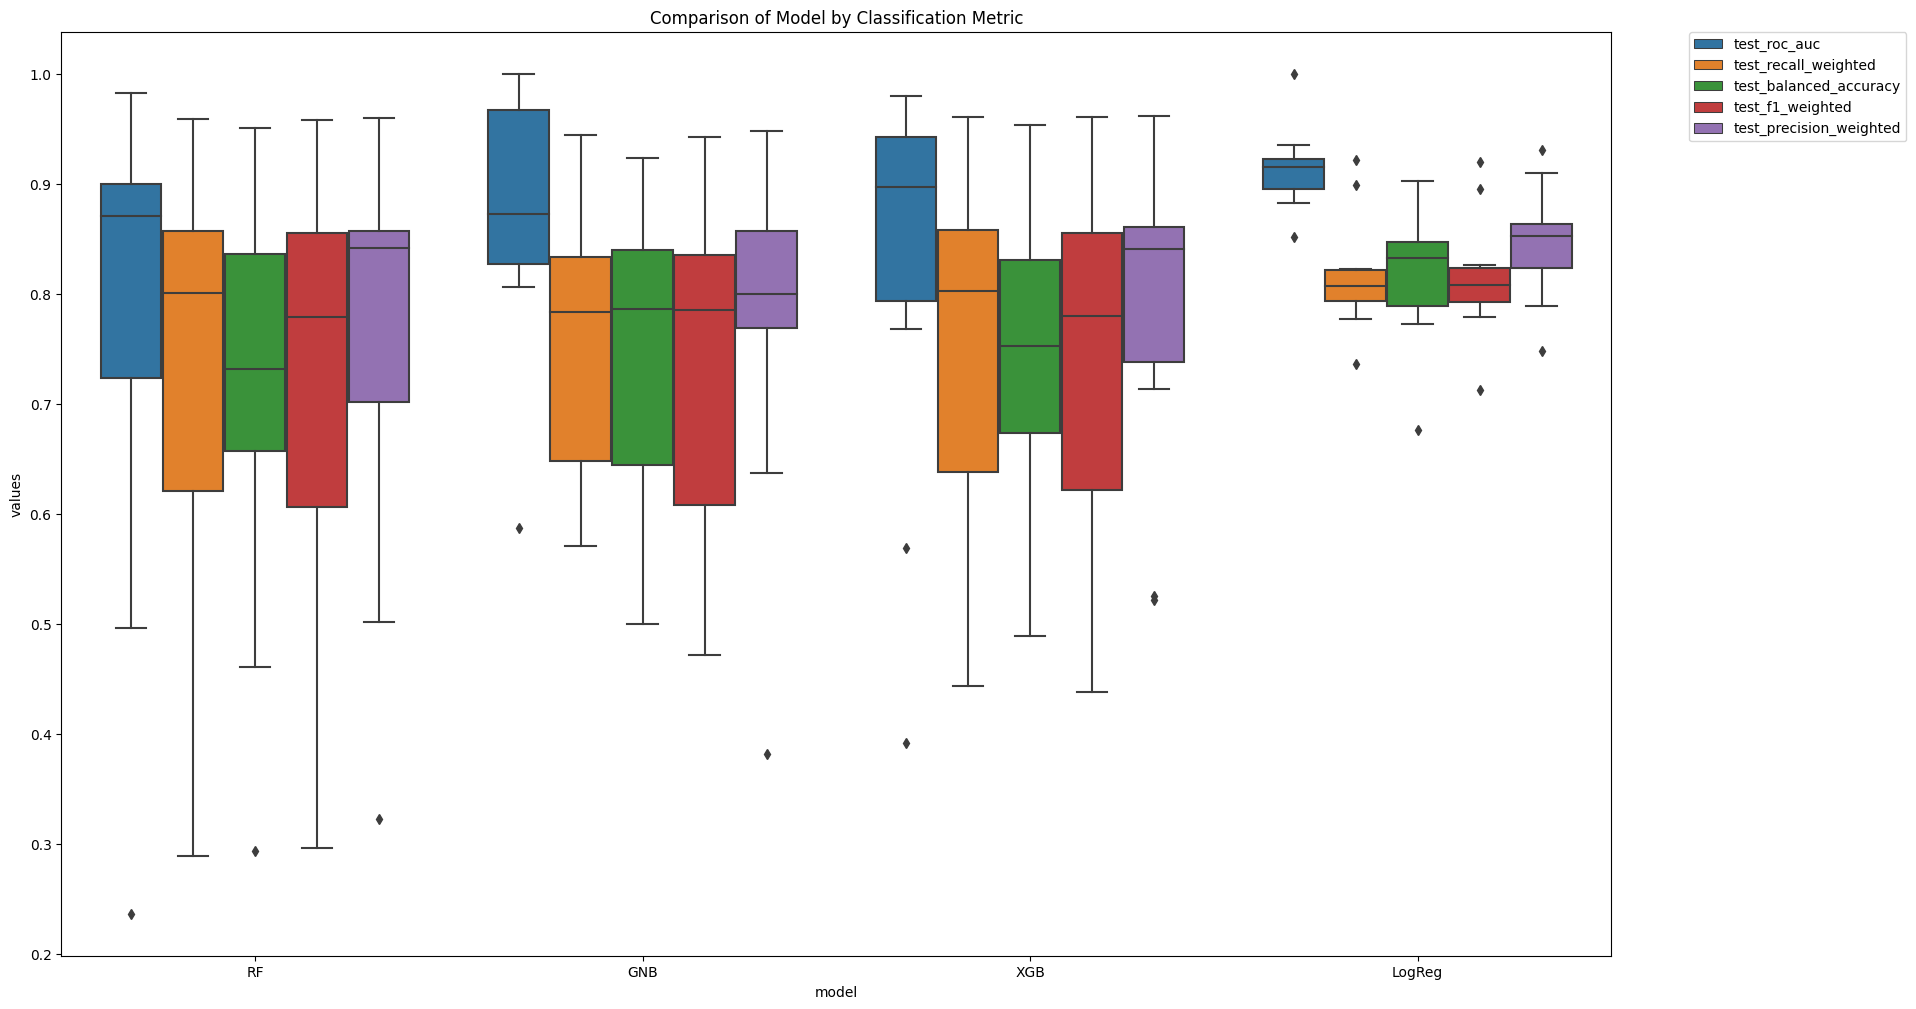

In [72]:
plt.figure(figsize=(20, 12))
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.show()

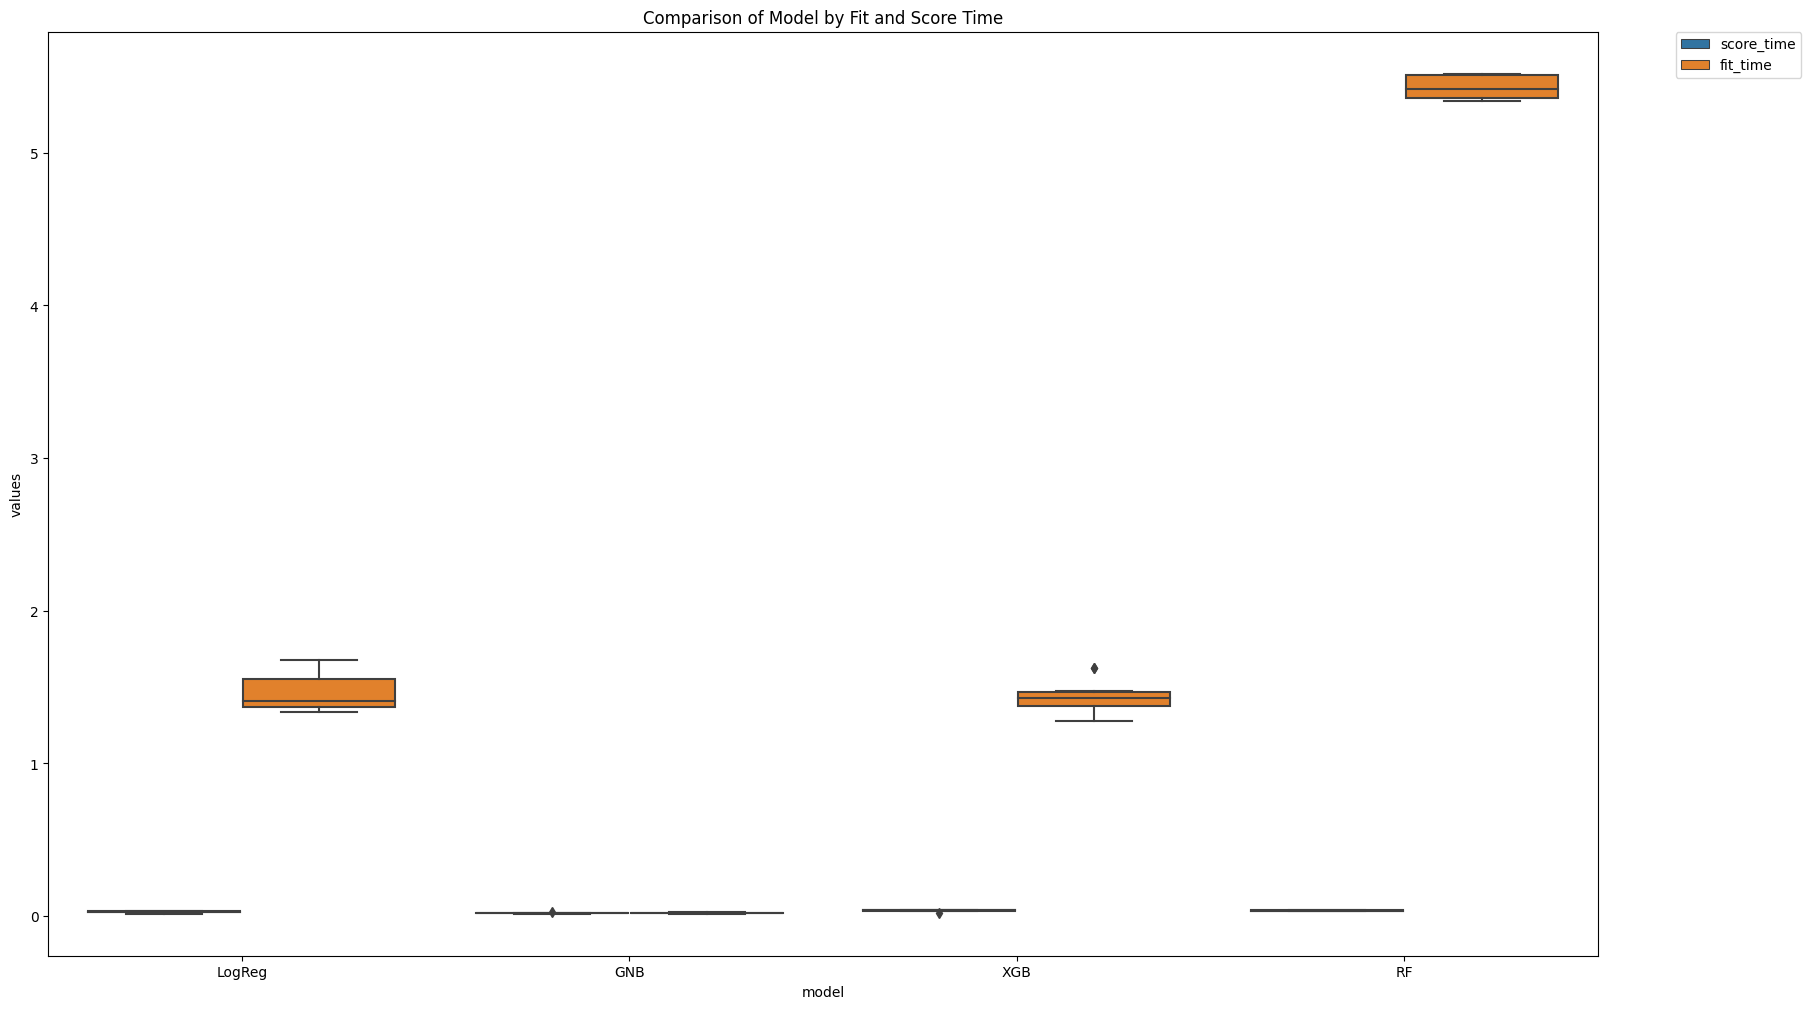

In [73]:
plt.figure(figsize=(20, 12))
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.show()

### Comparison

In [74]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_roc_auc           test_recall_weighted            \
                std      mean                  std      mean   
model                                                          
GNB        0.122849  0.868137             0.126059  0.759500   
LogReg     0.038712  0.913222             0.054899  0.818001   
RF         0.233357  0.768358             0.209526  0.722626   
XGB        0.194420  0.821513             0.166753  0.751453   

       test_balanced_accuracy           test_f1_weighted            \
                          std      mean              std      mean   
model                                                                
GNB                  0.151438  0.740708         0.167884  0.731490   
LogReg               0.063050  0.817743         0.058193  0.815860   
RF                   0.199105  0.704210         0.206248  0.716705   
XGB                  0.155451  0.732203         0.173564  0.738760   

       test_precision_weighted            
                           std      mean  
model                                     
GNB                   0.162967  0.773513  
LogReg                0.053570  0.847109  
RF                    0.200170  0.755350  
XGB                   0.151795  0.784158

In [75]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time            fit_time          
              std      mean       std      mean
model                                          
GNB      0.003339  0.019042  0.002345  0.020419
LogReg   0.005072  0.025550  0.123518  1.463087
RF       0.002636  0.035606  0.074287  5.430568
XGB      0.004727  0.036248  0.111681  1.444102

### Confusion Matrix

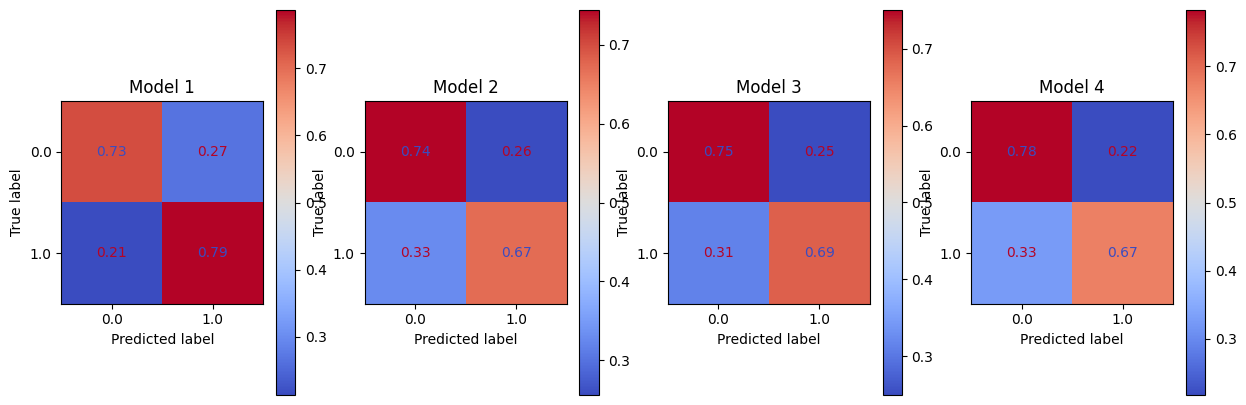

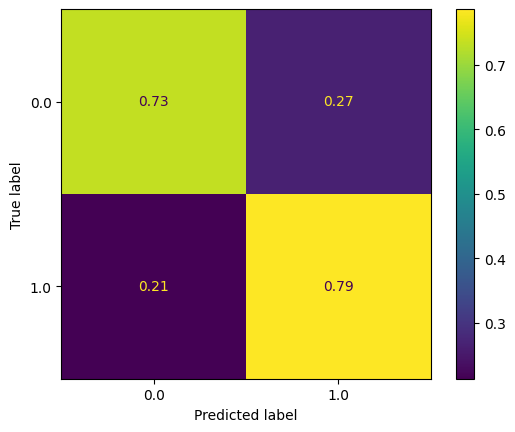

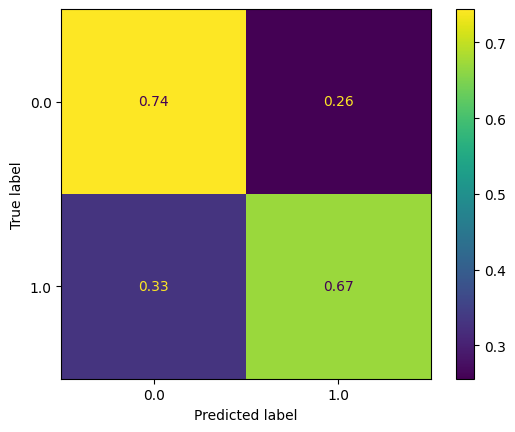

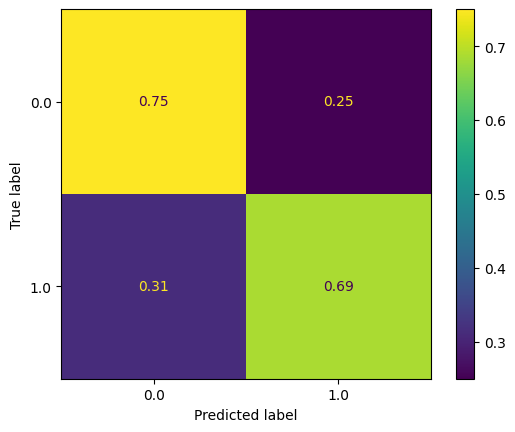

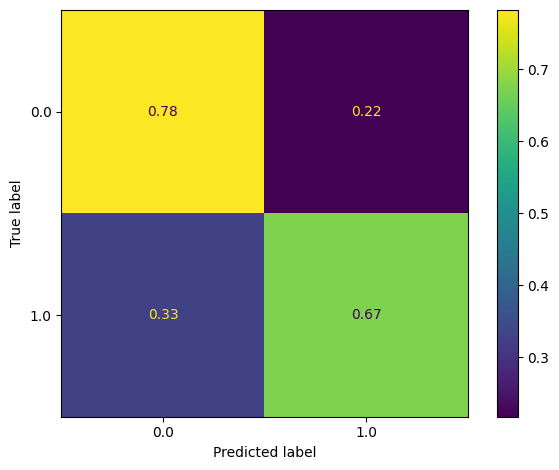

In [77]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, clf in enumerate([logreg_hyperparams.best_estimator_, rf_hyperparams.best_estimator_, gnb_hyperparams.best_estimator_, xgb_hyperparams.best_estimator_]):
    prediction = cross_val_predict(clf, X, y, cv=cv, groups=groups)
    disp = ConfusionMatrixDisplay.from_predictions(y, prediction, display_labels=np.unique(y), normalize='true')
    disp.plot(ax=axes[i], colorbar=True, cmap='coolwarm')
    disp.ax_.set_title(f"Model {i+1}")

plt.tight_layout()
#plt.show()

### McNemar's Test

In [82]:
logreg_pred = cross_val_predict(logreg, X, y, cv=cv, groups=groups)
gnb_pred = cross_val_predict(gnb, X, y, cv=cv, groups=groups)

In [84]:
tb = mcnemar_table(y_target=y, 
                   y_model1=logreg_pred, 
                   y_model2=gnb_pred, )

print(tb)

chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

[[19284  3338]
 [ 2513  4865]]
chi-squared: 116.04443684840199
p-value: 4.647651116708927e-27


### Interpretability

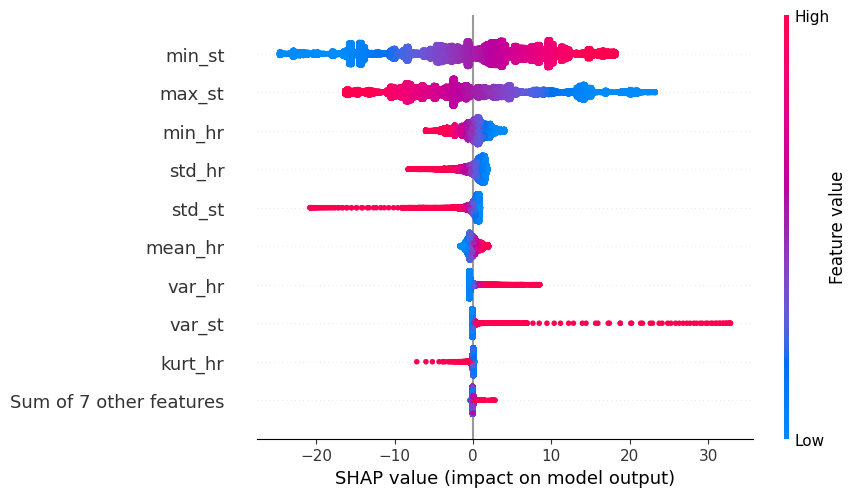

In [123]:
explainer = shap.Explainer(logreg, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

## Deploy

In [124]:
if __name__ == '__main__':
    classmap = {
        0: 'Baseline',
        1: 'Stress'
    }
    c_code = port(logreg_hyperparams.best_estimator_, classmap=classmap)

    with open('C:/Users/aless/OneDrive - Università degli Studi di Catania/tesi/codes/arduinocode/Final_code/Classifier.h', 'w') as file:
        file.write(c_code)

In [125]:
filename = 'C:/Users/aless/OneDrive - Università degli Studi di Catania/tesi/codes/ML and DL - Python/ML/classifier.sav'
pickle.dump(logreg_hyperparams.best_estimator_, open(filename, 'wb'))

In [4]:
model = pickle.load(open(filename, 'rb'))